In [3]:
import os
import json
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from collections import defaultdict

# Set font
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# =============================================
# Configuration - User provided
# =============================================

# Base directory for experiments
BASE_DIR = "/home/infres/zzhu-24/PRIM/VLM2Vec/experiments/public/exps"

# Model identifiers to analyze (user provided - REQUIRED)
# Format: list of tuples (eval_dir, model_dir_name, model_id_dir)
#   - eval_dir: relative path from BASE_DIR (e.g., "eval_cls_datasets") or absolute path
#   - model_dir_name: name of the model directory (e.g., "original-Qwen")
#   - model_id_dir: model ID directory (e.g., "qwen-Qwen2-VL-2B-Instruct")
# Example:
#   ("eval_cls_datasets", "original-Qwen", "qwen-Qwen2-VL-2B-Instruct")
#   means: BASE_DIR/eval_cls_datasets/original-Qwen/qwen-Qwen2-VL-2B-Instruct
MODEL_IDENTIFIERS = [
    # Add your models here, for example:
    ("eval_cls_datasets", "5Jan_Qwen3VL4b_rmv_21_7-Qwen", "qwen-Qwen3-VL-4B-Instruct"),
    ("eval_cls_datasets", "5Jan_Qwen3VL4b_rmv_28_7-Qwen", "qwen-Qwen3-VL-4B-Instruct"),
    ("eval_cls_datasets", "9Jan_Qwen3VL4b_rmv_14_7-Qwen", "qwen-Qwen3-VL-4B-Instruct"),
    ("eval_cls_datasets", "17Dec_Qwen3VL2B_original-Qwen", "qwen-Qwen3-VL-2B-Instruct"),
    ("eval_cls_datasets", "17Dec_Qwen3VL4B_rmv_35_7-Qwen", "qwen-Qwen3-VL-4B-Instruct"),
    # ("eval_cls_datasets", "original-Qwen", "qwen-Qwen2-VL-2B-Instruct"),
    ("eval_new_datasets", "5Jan_Qwen3VL4b_rmv_21_7-Qwen", "qwen-Qwen3-VL-4B-Instruct"),
    ("eval_new_datasets", "5Jan_Qwen3VL4b_rmv_28_7-Qwen", "qwen-Qwen3-VL-4B-Instruct"),
    ("eval_new_datasets", "9Jan_Qwen3VL4b_rmv_14_7-Qwen", "qwen-Qwen3-VL-4B-Instruct"),
    ("eval_new_datasets", "17Dec_Qwen3VL2B_original-Qwen", "qwen-Qwen3-VL-2B-Instruct"),
    ("eval_new_datasets", "17Dec_Qwen3VL4B_rmv_35_7-Qwen", "qwen-Qwen3-VL-4B-Instruct"),
    # ("eval_new_datasets", "original-Qwen", "qwen-Qwen2-VL-2B-Instruct"),
    ("eval_all", "18Jan_Qwen3VL4B_rmv_28_26_24_22_20_18_16-Qwen", "qwen-Qwen3-VL-4B-Instruct"),
    ("eval_all", "Qwen3VL4B_uploaded", "qwen-Qwen3-VL-4B-Instruct"),
    ("eval_all", "23Jan_Qwen3VL4B_rmv_28_14_more_datasets-Qwen", "qwen-Qwen3-VL-4B-Instruct"),
    ("eval_all", "21Jan_Qwen3VL4B_rmv_28_14-Qwen", "qwen-Qwen3-VL-4B-Instruct"),
    ("eval_all", "28Jan_Qwen3VL4B_rmv_30_23-Qwen", "qwen-Qwen3-VL-4B-Instruct"),
]

# Custom model labels mapping (user provided)
# Key: model identifier (model_dir_name/model_id_dir), Value: custom display label
# If a model is not in this dict, the original path-based name will be used
MODEL_LABELS = {
    # Example:
    # "original-Qwen/qwen-Qwen2-VL-2B-Instruct": "Qwen2-VL-2B (Original)",
    "Qwen3VL4B_uploaded/qwen-Qwen3-VL-4B-Instruct": "Qwen3-VL-4B",
    "17Dec_Qwen3VL4B_rmv_35_7-Qwen/qwen-Qwen3-VL-4B-Instruct": "Qwen3-VL-4B (Remove 35-29)",
    "5Jan_Qwen3VL4b_rmv_28_7-Qwen/qwen-Qwen3-VL-4B-Instruct": "Qwen3-VL-4B (Remove 28-22)",
    "5Jan_Qwen3VL4b_rmv_21_7-Qwen/qwen-Qwen3-VL-4B-Instruct": "Qwen3-VL-4B (Remove 21-15)",
    "9Jan_Qwen3VL4b_rmv_14_7-Qwen/qwen-Qwen3-VL-4B-Instruct": "Qwen3-VL-4B (Remove 14-8)",
    "18Jan_Qwen3VL4B_rmv_28_26_24_22_20_18_16-Qwen/qwen-Qwen3-VL-4B-Instruct": "Qwen3-VL-4B (Remove alternately)",
    "17Dec_Qwen3VL2B_original-Qwen/qwen-Qwen3-VL-2B-Instruct": "Qwen3-VL-2B",
    "23Jan_Qwen3VL4B_rmv_28_14_more_datasets-Qwen/qwen-Qwen3-VL-4B-Instruct": "Qwen3-VL-4B (Remove 28-14) (Trained on more datasets)",
    "21Jan_Qwen3VL4B_rmv_28_14-Qwen/qwen-Qwen3-VL-4B-Instruct": "Qwen3-VL-4B (Remove 28-14)",
    "28Jan_Qwen3VL4B_rmv_30_23-Qwen/qwen-Qwen3-VL-4B-Instruct": "Qwen3-VL-4B (Remove 30-23) (Trained on more datasets)",
}

# YAML configuration file paths
RETRIEVAL_YAML = "/home/infres/zzhu-24/PRIM/VLM2Vec/experiments/public/eval/retrieval.yaml"
IMAGE_CLS_YAML = "/home/infres/zzhu-24/PRIM/VLM2Vec/experiments/public/eval/image_cls.yaml"
ALL_IMAGE_YAML = "/home/infres/zzhu-24/PRIM/VLM2Vec/experiments/public/eval/image_all.yaml"

# Metrics to extract (can be modified as needed)
METRICS = ["hit@1", "ndcg_linear@1", "ndcg_exponential@1"]

# =============================================
# Helper functions
# =============================================

def load_datasets_from_yaml(yaml_path):
    """Load dataset list from YAML file"""
    datasets = []
    if os.path.exists(yaml_path):
        with open(yaml_path, 'r', encoding='utf-8') as f:
            content = yaml.safe_load(f)
            if content:
                for dataset_name in content.keys():
                    if not dataset_name.startswith('#'):
                        datasets.append(dataset_name)
    return datasets

def extract_checkpoint_from_path(path):
    """Extract checkpoint information from path"""
    parts = path.split('/')
    for part in parts:
        if part.startswith('checkpoint-'):
            try:
                return int(part.replace('checkpoint-', ''))
            except ValueError:
                return 0
    return 0

def get_model_label(model_identifier):
    """Get custom label for model, or return original identifier if not found"""
    return MODEL_LABELS.get(model_identifier, model_identifier)

def resolve_eval_dir(eval_dir_spec):
    """Resolve eval directory path - can be relative to BASE_DIR or absolute"""
    if os.path.isabs(eval_dir_spec):
        return eval_dir_spec
    else:
        return os.path.join(BASE_DIR, eval_dir_spec)

def collect_eval_results():
    """Collect evaluation results - only the latest checkpoint for each specified model"""
    all_results = []
    
    # Load dataset list from YAML files
    # retrieval_datasets = load_datasets_from_yaml(RETRIEVAL_YAML)
    # cls_datasets = load_datasets_from_yaml(IMAGE_CLS_YAML)
    # all_datasets = retrieval_datasets + cls_datasets
    all_datasets = load_datasets_from_yaml(ALL_IMAGE_YAML)
    
    print(f"Loaded {len(all_datasets)} datasets from YAML files")
    # print(f"Retrieval datasets: {retrieval_datasets}")
    # print(f"Classification datasets: {cls_datasets}")
    print(f"All datasets: {all_datasets}")
    
    if not MODEL_IDENTIFIERS:
        print("⚠️  No model identifiers provided. Please specify models in MODEL_IDENTIFIERS.")
        return pd.DataFrame()
    
    print(f"\n📋 Processing {len(MODEL_IDENTIFIERS)} specified models...")
    
    # Process each specified model
    for eval_dir_spec, model_dir_name, model_id_dir in MODEL_IDENTIFIERS:
        # Resolve eval directory path
        eval_dir = resolve_eval_dir(eval_dir_spec)
        
        if not os.path.exists(eval_dir):
            print(f"⚠️  Evaluation directory does not exist: {eval_dir}")
            continue
        
        # Construct model path
        model_dir_path = os.path.join(eval_dir, model_dir_name)
        if not os.path.exists(model_dir_path):
            print(f"⚠️  Model directory does not exist: {model_dir_path}")
            continue
        
        model_id_path = os.path.join(model_dir_path, model_id_dir)
        if not os.path.exists(model_id_path):
            print(f"⚠️  Model ID directory does not exist: {model_id_path}")
            continue
        
        model_identifier = f"{model_dir_name}/{model_id_dir}"
        
        # Collect all checkpoints for this model
        checkpoints = []
        for checkpoint_dir in os.listdir(model_id_path):
            if not checkpoint_dir.startswith('checkpoint-'):
                continue
            checkpoint_path = os.path.join(model_id_path, checkpoint_dir)
            retrieval_path = os.path.join(checkpoint_path, 'retrieval')
            if os.path.exists(retrieval_path):
                checkpoint_num = extract_checkpoint_from_path(checkpoint_path)
                checkpoints.append((checkpoint_num, checkpoint_path))
        
        if not checkpoints:
            print(f"⚠️  No checkpoints found for model: {model_identifier}")
            continue
        
        # Only keep the latest checkpoint (highest checkpoint number)
        checkpoints.sort(key=lambda x: x[0], reverse=True)
        latest_checkpoint_num, latest_checkpoint_path = checkpoints[0]
        print(f"  ✓ {model_identifier} -> Using checkpoint {latest_checkpoint_num}")
        
        # Collect results from the latest checkpoint
        retrieval_path = os.path.join(latest_checkpoint_path, 'retrieval')
        
        if not os.path.exists(retrieval_path):
            print(f"⚠️  Retrieval directory does not exist: {retrieval_path}")
            continue
        
        # Find layer_-1 directory (or other layer directories)
        layer_dirs = [d for d in os.listdir(retrieval_path) if d.startswith('layer_')]
        
        for layer_dir in layer_dirs:
            layer_path = os.path.join(retrieval_path, layer_dir)
            
            # Iterate through result files for all datasets
            for dataset_name in all_datasets:
                score_file = os.path.join(layer_path, f"{dataset_name}_score.json")
                
                if os.path.exists(score_file):
                    try:
                        with open(score_file, 'r') as f:
                            score_data = json.load(f)
                        
                        # Use custom label if available
                        model_label = get_model_label(model_identifier)
                        
                        record = {
                            'model_name': model_label,  # Use custom label
                            'model_identifier': model_identifier,  # Keep original for reference
                            'model_dir': model_dir_name,
                            'model_id': model_id_dir,
                            'dataset': dataset_name,
                            'layer': layer_dir,
                        }
                        
                        # Extract metrics
                        for metric in METRICS:
                            record[metric] = score_data.get(metric, None)
                        
                        all_results.append(record)
                        
                    except Exception as e:
                        print(f"⚠️  Failed to read file {score_file}: {e}")
    
    df = pd.DataFrame(all_results)
    print(f"\n✅ Collected {len(df)} evaluation results")
    return df

# Collect data
df_results = collect_eval_results()

if len(df_results) > 0:
    print("\nData preview:")
    print(df_results.head())
    print(f"\nDataset list: {df_results['dataset'].unique()}")
    print(f"Model list: {df_results['model_name'].unique()}")
    print(f"\nTotal models: {df_results['model_name'].nunique()}")
    print(f"Total datasets: {df_results['dataset'].nunique()}")
else:
    print("⚠️  No evaluation results found")

Loaded 11 datasets from YAML files
All datasets: ['MSCOCO_i2t', 'MSCOCO_t2i', 'N24News', 'HatefulMemes', 'VOC2007', 'Place365', 'Country211', 'VisualNews_i2t', 'VisualNews_t2i', 'WebQA', 'EDIS']

📋 Processing 15 specified models...
  ✓ 5Jan_Qwen3VL4b_rmv_21_7-Qwen/qwen-Qwen3-VL-4B-Instruct -> Using checkpoint 4000
  ✓ 5Jan_Qwen3VL4b_rmv_28_7-Qwen/qwen-Qwen3-VL-4B-Instruct -> Using checkpoint 4000
  ✓ 9Jan_Qwen3VL4b_rmv_14_7-Qwen/qwen-Qwen3-VL-4B-Instruct -> Using checkpoint 4000
  ✓ 17Dec_Qwen3VL2B_original-Qwen/qwen-Qwen3-VL-2B-Instruct -> Using checkpoint 5000
  ✓ 17Dec_Qwen3VL4B_rmv_35_7-Qwen/qwen-Qwen3-VL-4B-Instruct -> Using checkpoint 4500
  ✓ 5Jan_Qwen3VL4b_rmv_21_7-Qwen/qwen-Qwen3-VL-4B-Instruct -> Using checkpoint 4000
  ✓ 5Jan_Qwen3VL4b_rmv_28_7-Qwen/qwen-Qwen3-VL-4B-Instruct -> Using checkpoint 4000
  ✓ 9Jan_Qwen3VL4b_rmv_14_7-Qwen/qwen-Qwen3-VL-4B-Instruct -> Using checkpoint 4000
  ✓ 17Dec_Qwen3VL2B_original-Qwen/qwen-Qwen3-VL-2B-Instruct -> Using checkpoint 5000
  ✓ 17Dec

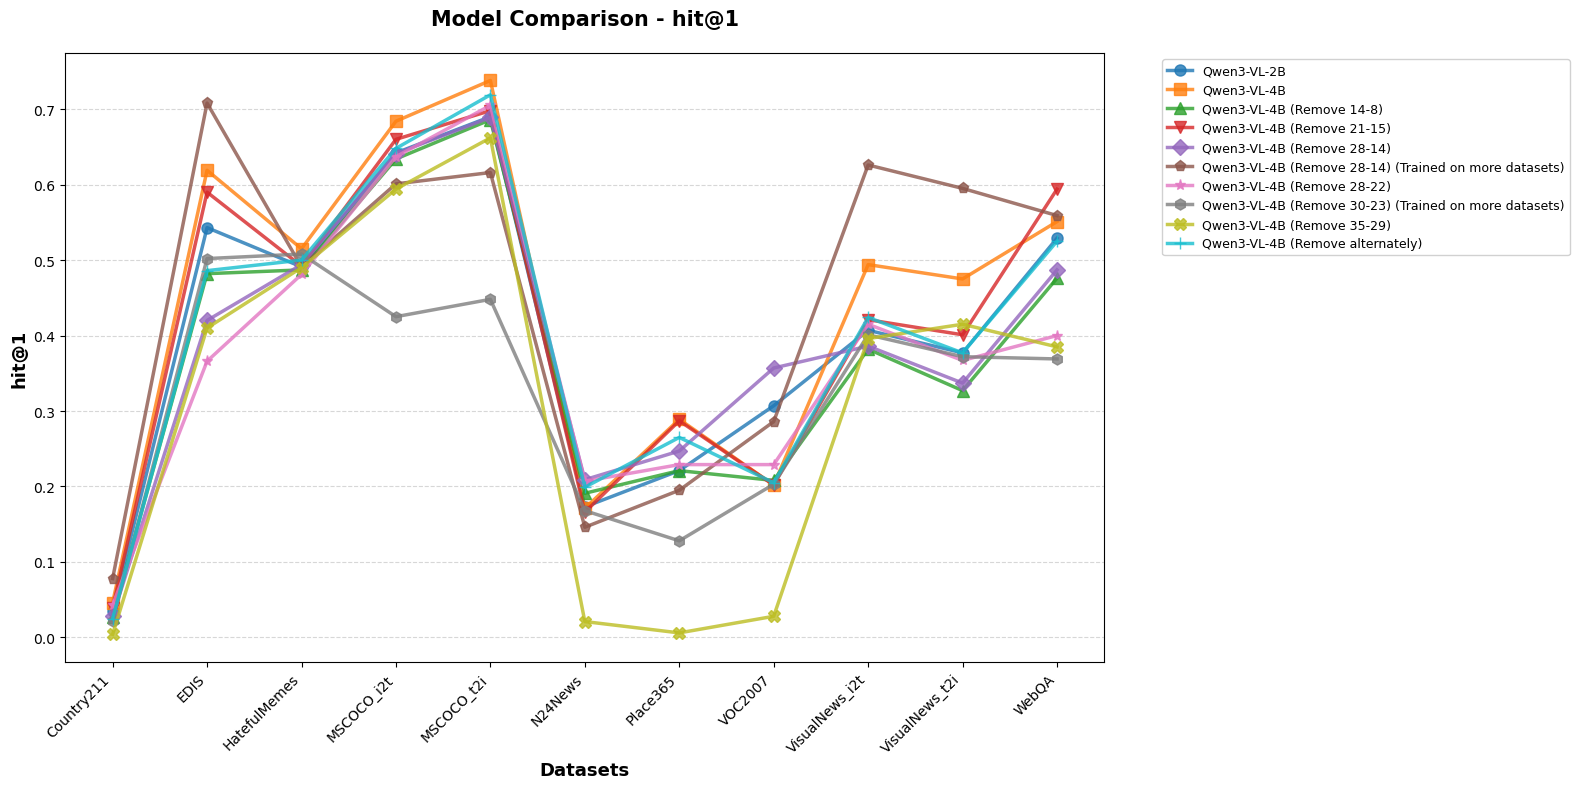

✅ Generated chart: hit@1


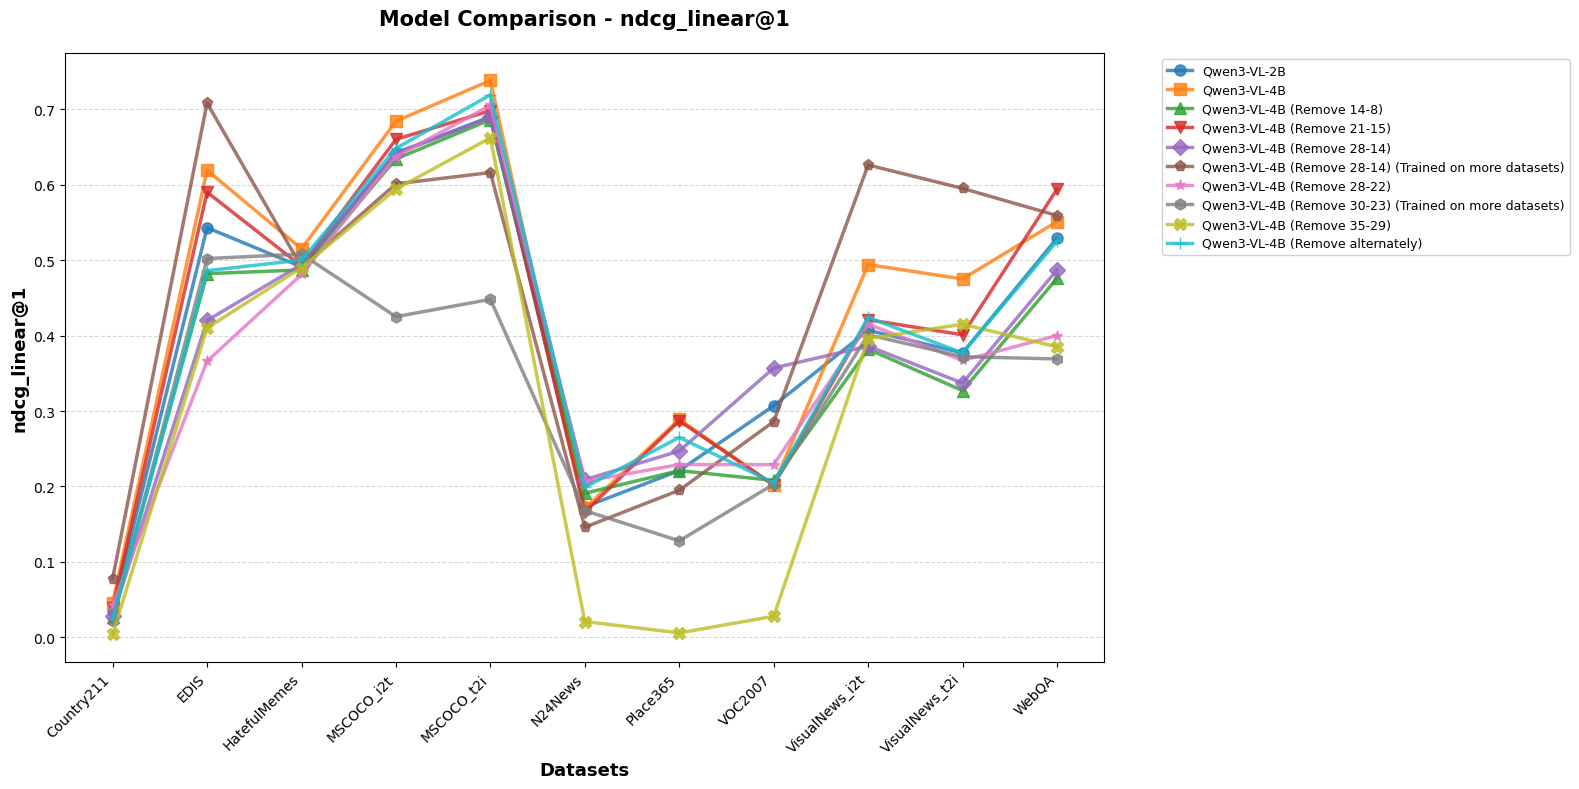

✅ Generated chart: ndcg_linear@1


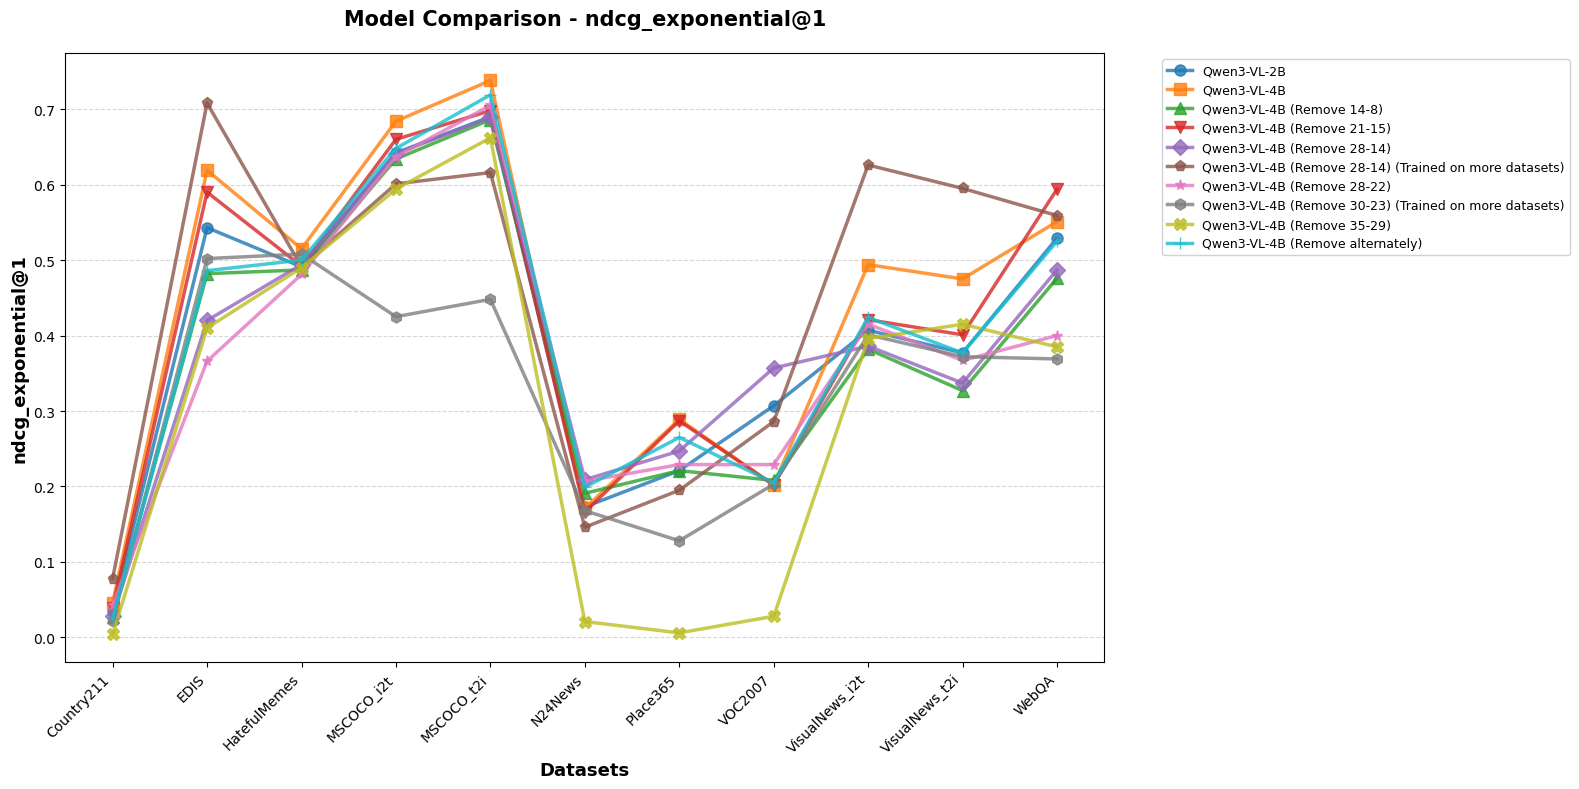

✅ Generated chart: ndcg_exponential@1


In [5]:
# =============================================
# Visualization: Model comparison chart
# X-axis: datasets, Y-axis: evaluation results, each line represents a model
# =============================================

if len(df_results) > 0:
    # Plot a chart for each metric
    for metric in METRICS:
        # Check if the metric has data
        if df_results[metric].notna().sum() == 0:
            continue
        
        plt.figure(figsize=(16, 8))
        
        # Get all models and datasets
        models = sorted(df_results['model_name'].unique())
        datasets = sorted(df_results['dataset'].unique())
        
        if len(models) == 0 or len(datasets) == 0:
            continue
        
        # Draw a line for each model
        x_positions = np.arange(len(datasets))
        
        # Use different colors and marker styles
        colors = plt.cm.tab10(np.linspace(0, 1, len(models)))
        markers = ['o', 's', '^', 'v', 'D', 'p', '*', 'h', 'X', '+']
        
        for idx, model in enumerate(models):
            model_data = df_results[df_results['model_name'] == model]
            values = []
            
            for dataset in datasets:
                dataset_data = model_data[model_data['dataset'] == dataset]
                if len(dataset_data) > 0:
                    # Prefer layer_-1, otherwise use first available
                    if 'layer' in dataset_data.columns:
                        layer_minus1_data = dataset_data[dataset_data['layer'] == 'layer_-1']
                        if len(layer_minus1_data) > 0:
                            value = layer_minus1_data[metric].iloc[0]
                        else:
                            value = dataset_data[metric].iloc[0]
                    else:
                        value = dataset_data[metric].iloc[0]
                    values.append(value if pd.notna(value) else None)
                else:
                    values.append(None)
            
            # Filter out None values for correct plotting
            valid_indices = [i for i, v in enumerate(values) if v is not None]
            valid_x = [x_positions[i] for i in valid_indices]
            valid_values = [values[i] for i in valid_indices]
            
            if len(valid_values) > 0:
                marker_style = markers[idx % len(markers)]
                plt.plot(valid_x, valid_values, marker=marker_style, label=model, 
                        linewidth=2.5, markersize=8, color=colors[idx], alpha=0.8)
        
        plt.xlabel('Datasets', fontsize=13, fontweight='bold')
        plt.ylabel(metric, fontsize=13, fontweight='bold')
        plt.title(f'Model Comparison - {metric}', fontsize=15, fontweight='bold', pad=20)
        plt.xticks(x_positions, datasets, rotation=45, ha='right', fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.5, axis='y')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, framealpha=0.9)
        plt.tight_layout()
        plt.show()
        
        print(f"✅ Generated chart: {metric}")
else:
    print("⚠️  No data available for visualization")

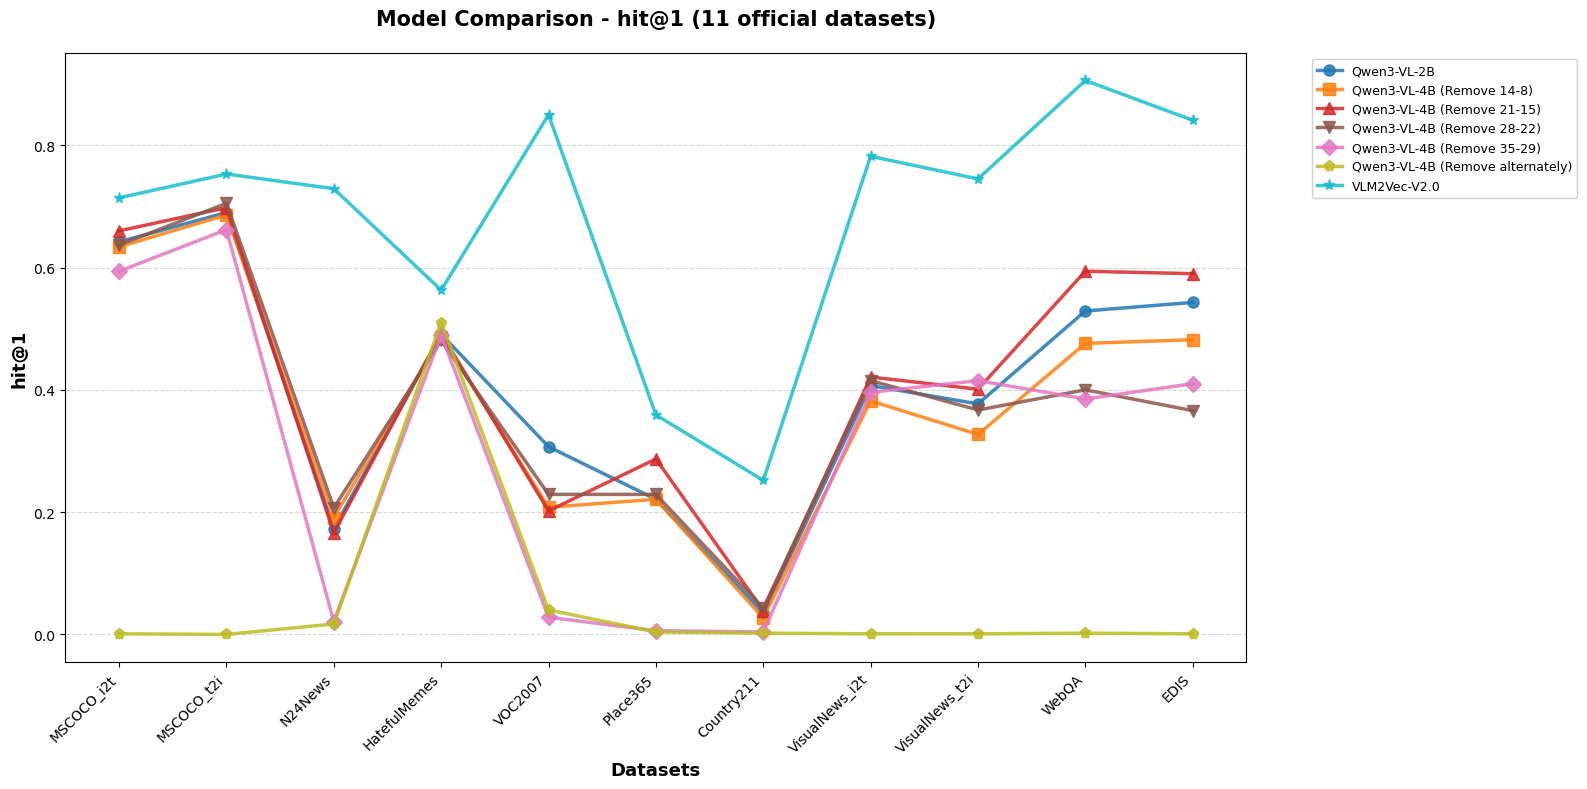

✅ Generated chart: hit@1


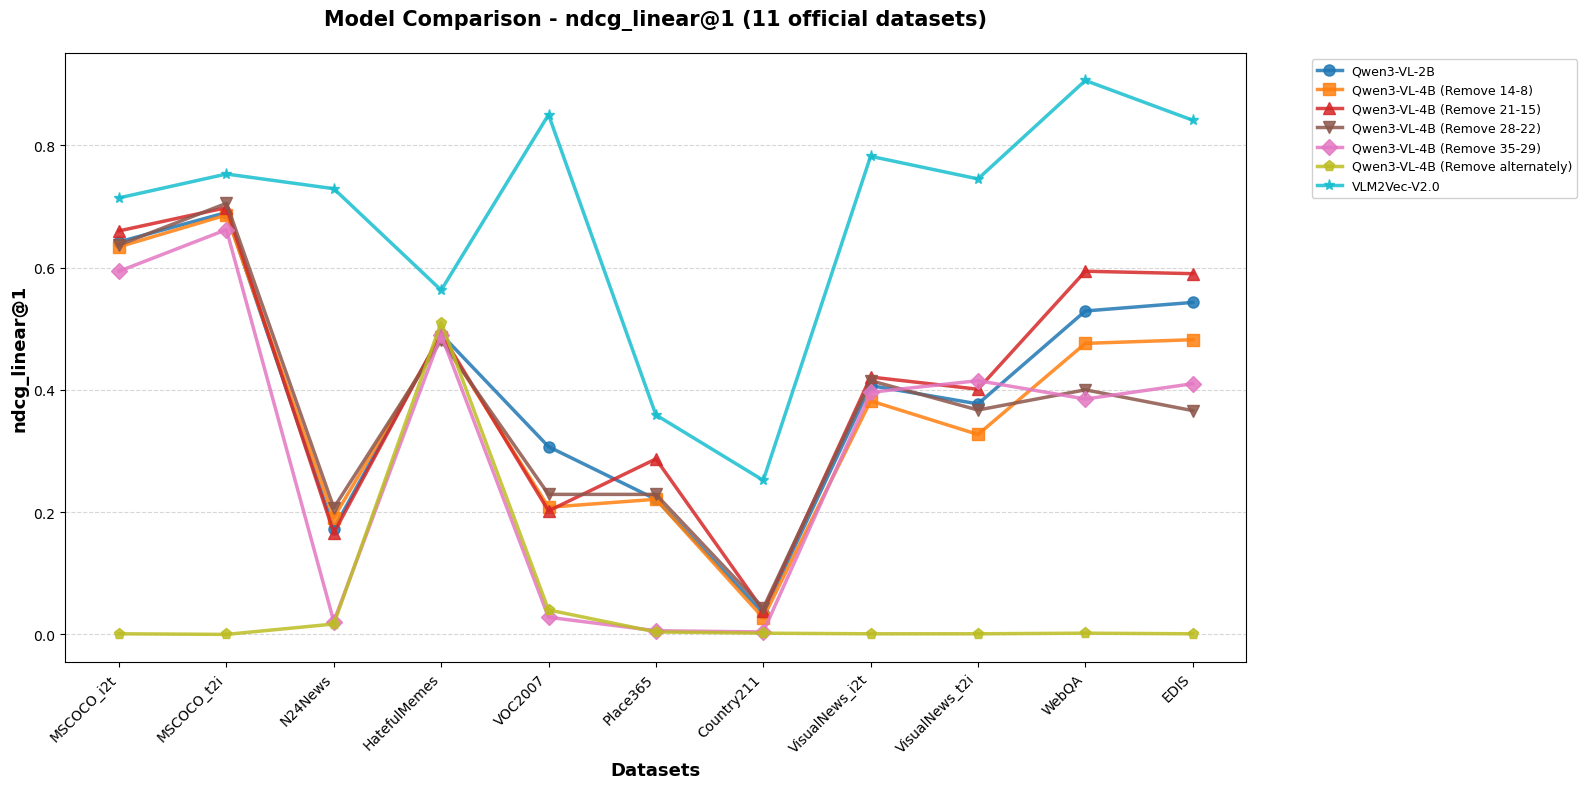

✅ Generated chart: ndcg_linear@1


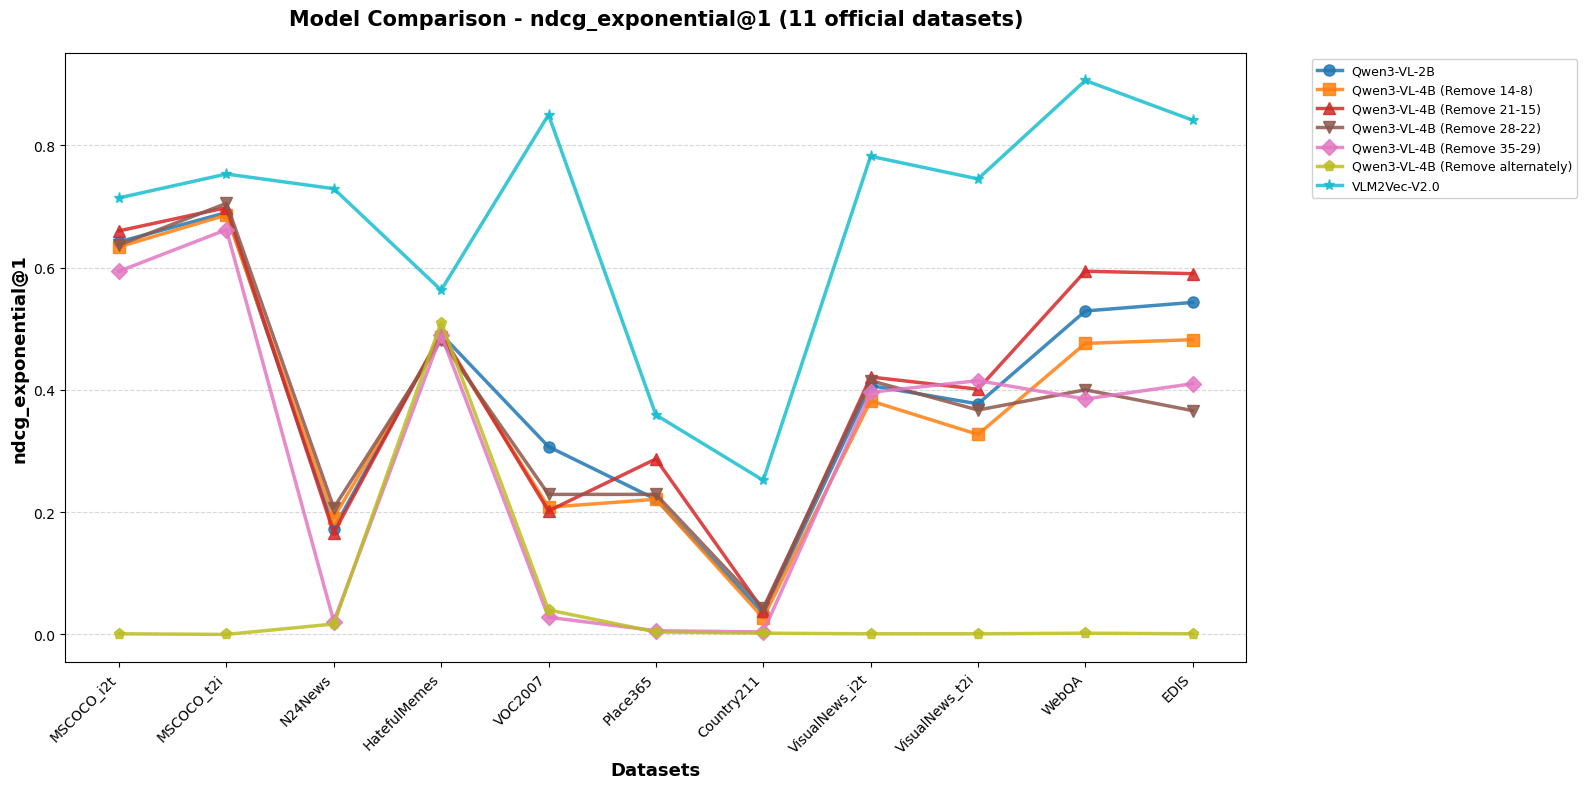

✅ Generated chart: ndcg_exponential@1


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Official VLM2Vec(V2.0) results
# -----------------------------
vlm2vec_v2_official_pct = {
    "MSCOCO_i2t": 71.4,
    "MSCOCO_t2i": 75.3,
    "N24News": 72.9,
    "HatefulMemes": 56.3,
    "VOC2007": 85.0,
    "Place365": 35.9,
    "Country211": 25.2,
    "VisualNews_i2t": 78.2,
    "VisualNews_t2i": 74.5,
    "WebQA": 90.6,
    "EDIS": 84.1,
}

VLM2VEC_MODEL_NAME = "VLM2Vec-V2.0"

# Convert to [0,1] scale (your df uses decimals like 0.166)
vlm2vec_v2_official = {k: v / 100.0 for k, v in vlm2vec_v2_official_pct.items()}

# --------------------------------------
# Inject rows into df_results (overwrite)
# --------------------------------------
required_cols = ["model_name", "dataset"]
for c in required_cols:
    if c not in df_results.columns:
        raise ValueError(f"df_results missing column: {c}")

# Which metric columns to fill
metric_cols = ["hit@1", "ndcg_linear@1", "ndcg_exponential@1"]
metric_cols = [c for c in metric_cols if c in df_results.columns]
if len(metric_cols) == 0:
    raise ValueError("No metric columns found in df_results.")

# Remove old official rows if exist (avoid duplicates)
mask_existing = (
    (df_results["model_name"] == VLM2VEC_MODEL_NAME)
    & (df_results["dataset"].isin(vlm2vec_v2_official.keys()))
)
df_results = df_results.loc[~mask_existing].copy()

# Build official rows
rows = []
for ds, score in vlm2vec_v2_official.items():
    row = {col: np.nan for col in df_results.columns}

    row["model_name"] = VLM2VEC_MODEL_NAME
    row["dataset"] = ds

    # If you want, you can also set these to something meaningful
    # row["layer"] = "official"

    for mc in metric_cols:
        row[mc] = score

    rows.append(row)

df_results = pd.concat([df_results, pd.DataFrame(rows)], ignore_index=True)

# --------------------------------------
# Plot: only these 11 datasets (clean!)
# --------------------------------------
datasets_order = list(vlm2vec_v2_official.keys())
df_plot = df_results[df_results["dataset"].isin(datasets_order)].copy()
df_plot["dataset"] = pd.Categorical(df_plot["dataset"], categories=datasets_order, ordered=True)

METRICS = metric_cols  # override your METRICS to real columns

# =============================================
# Visualization: Model comparison chart
# X-axis: datasets, Y-axis: evaluation results, each line represents a model
# =============================================
if len(df_plot) > 0:
    for metric in METRICS:
        if df_plot[metric].notna().sum() == 0:
            continue

        plt.figure(figsize=(16, 8))

        models = sorted(df_plot["model_name"].unique())
        datasets = list(df_plot["dataset"].cat.categories)
        x_positions = np.arange(len(datasets))

        colors = plt.cm.tab10(np.linspace(0, 1, len(models)))
        markers = ["o", "s", "^", "v", "D", "p", "*", "h", "X", "+"]

        for idx, model in enumerate(models):
            model_data = df_plot[df_plot["model_name"] == model]
            values = []

            for dataset in datasets:
                dataset_data = model_data[model_data["dataset"] == dataset]
                if len(dataset_data) > 0:
                    # Prefer layer_-1, otherwise use first available
                    if 'layer' in dataset_data.columns:
                        layer_minus1_data = dataset_data[dataset_data['layer'] == 'layer_-1']
                        if len(layer_minus1_data) > 0:
                            value = layer_minus1_data[metric].iloc[0]
                        else:
                            value = dataset_data[metric].iloc[0]
                    else:
                        value = dataset_data[metric].iloc[0]
                    values.append(value if pd.notna(value) else None)
                else:
                    values.append(None)

            valid_indices = [i for i, v in enumerate(values) if v is not None]
            valid_x = [x_positions[i] for i in valid_indices]
            valid_values = [values[i] for i in valid_indices]

            if len(valid_values) > 0:
                plt.plot(
                    valid_x,
                    valid_values,
                    marker=markers[idx % len(markers)],
                    label=model,
                    linewidth=2.5,
                    markersize=8,
                    color=colors[idx],
                    alpha=0.85,
                )

        plt.xlabel("Datasets", fontsize=13, fontweight="bold")
        plt.ylabel(metric, fontsize=13, fontweight="bold")
        plt.title(f"Model Comparison - {metric} (11 official datasets)", fontsize=15, fontweight="bold", pad=20)
        plt.xticks(x_positions, datasets, rotation=45, ha="right", fontsize=10)
        plt.grid(True, linestyle="--", alpha=0.5, axis="y")
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9, framealpha=0.9)

        plt.tight_layout()
        plt.show()

        print(f"✅ Generated chart: {metric}")
else:
    print("⚠️  No data available for visualization")


CLS datasets: ['N24News', 'HatefulMemes', 'VOC2007', 'Place365', 'Country211']
Retrieval datasets: ['MSCOCO_i2t', 'MSCOCO_t2i']

Computing averages for metric: hit@1 ...


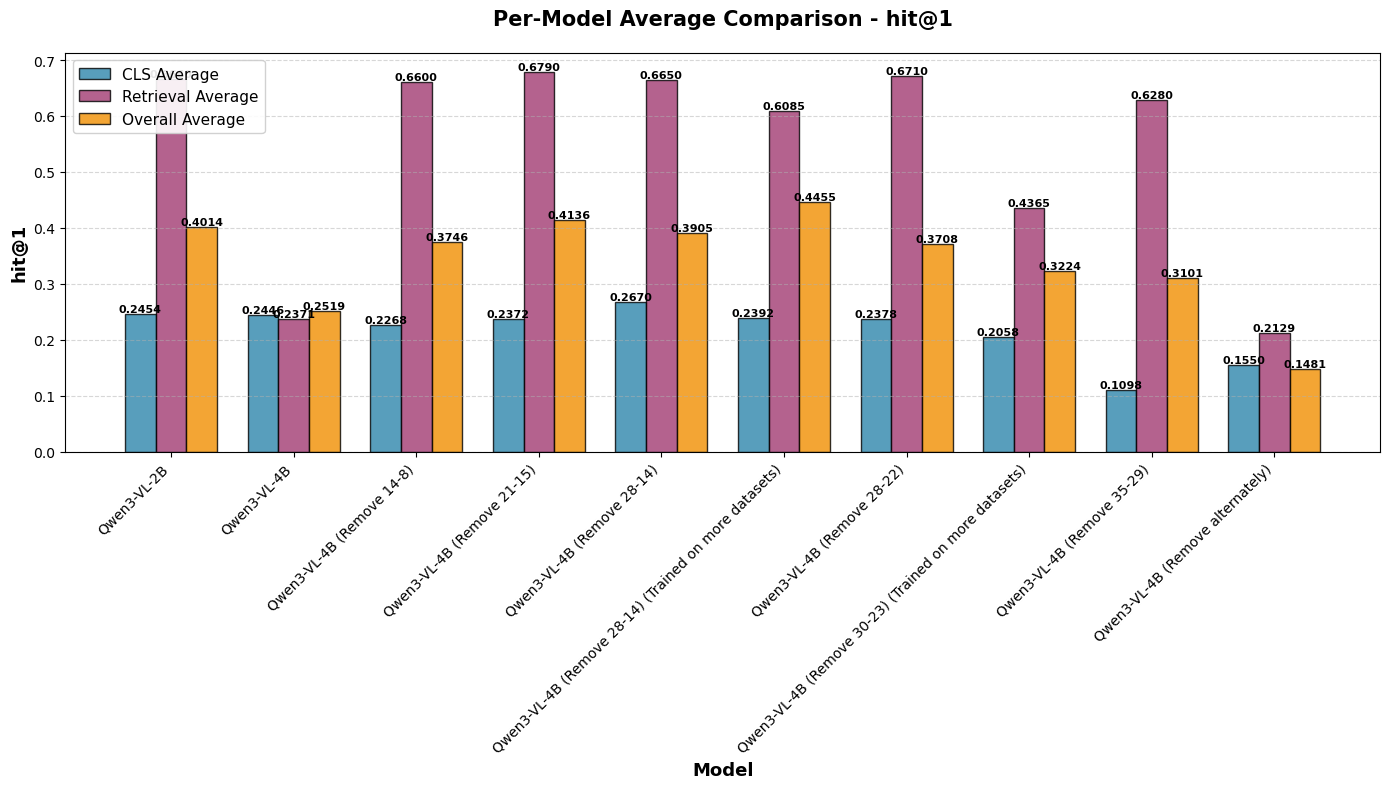


Averages for metric: hit@1
----------------------------------------------------------------------------------------------------
Model                                              CLS Avg         Retrieval Avg        Overall Avg    
----------------------------------------------------------------------------------------------------
Qwen3-VL-2B                                        0.2454          0.6660               0.4014         
Qwen3-VL-4B                                        0.2446          0.2371               0.2519         
Qwen3-VL-4B (Remove 14-8)                          0.2268          0.6600               0.3746         
Qwen3-VL-4B (Remove 21-15)                         0.2372          0.6790               0.4136         
Qwen3-VL-4B (Remove 28-14)                         0.2670          0.6650               0.3905         
Qwen3-VL-4B (Remove 28-14) (Trained on more datasets) 0.2392          0.6085               0.4455         
Qwen3-VL-4B (Remove 28-22)             

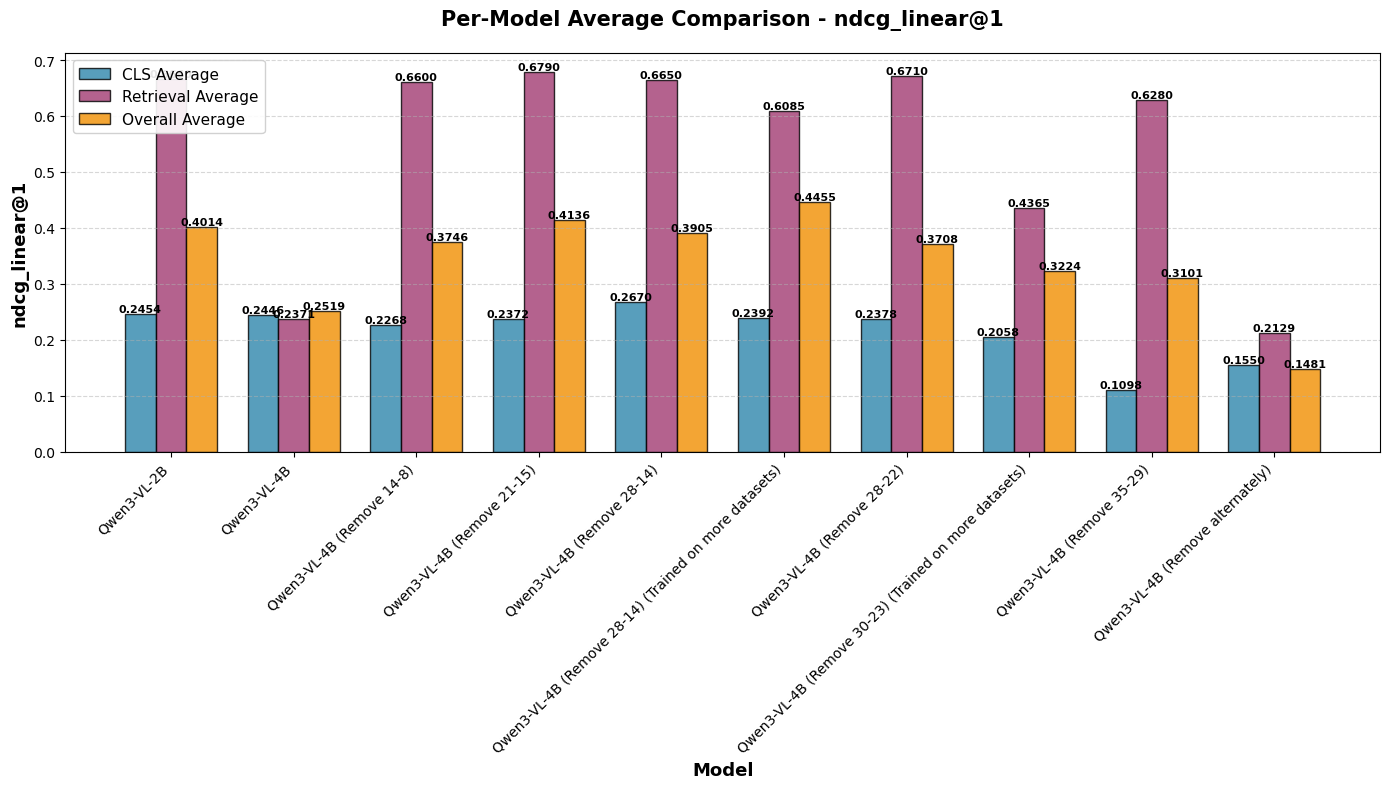


Averages for metric: ndcg_linear@1
----------------------------------------------------------------------------------------------------
Model                                              CLS Avg         Retrieval Avg        Overall Avg    
----------------------------------------------------------------------------------------------------
Qwen3-VL-2B                                        0.2454          0.6660               0.4014         
Qwen3-VL-4B                                        0.2446          0.2371               0.2519         
Qwen3-VL-4B (Remove 14-8)                          0.2268          0.6600               0.3746         
Qwen3-VL-4B (Remove 21-15)                         0.2372          0.6790               0.4136         
Qwen3-VL-4B (Remove 28-14)                         0.2670          0.6650               0.3905         
Qwen3-VL-4B (Remove 28-14) (Trained on more datasets) 0.2392          0.6085               0.4455         
Qwen3-VL-4B (Remove 28-22)     

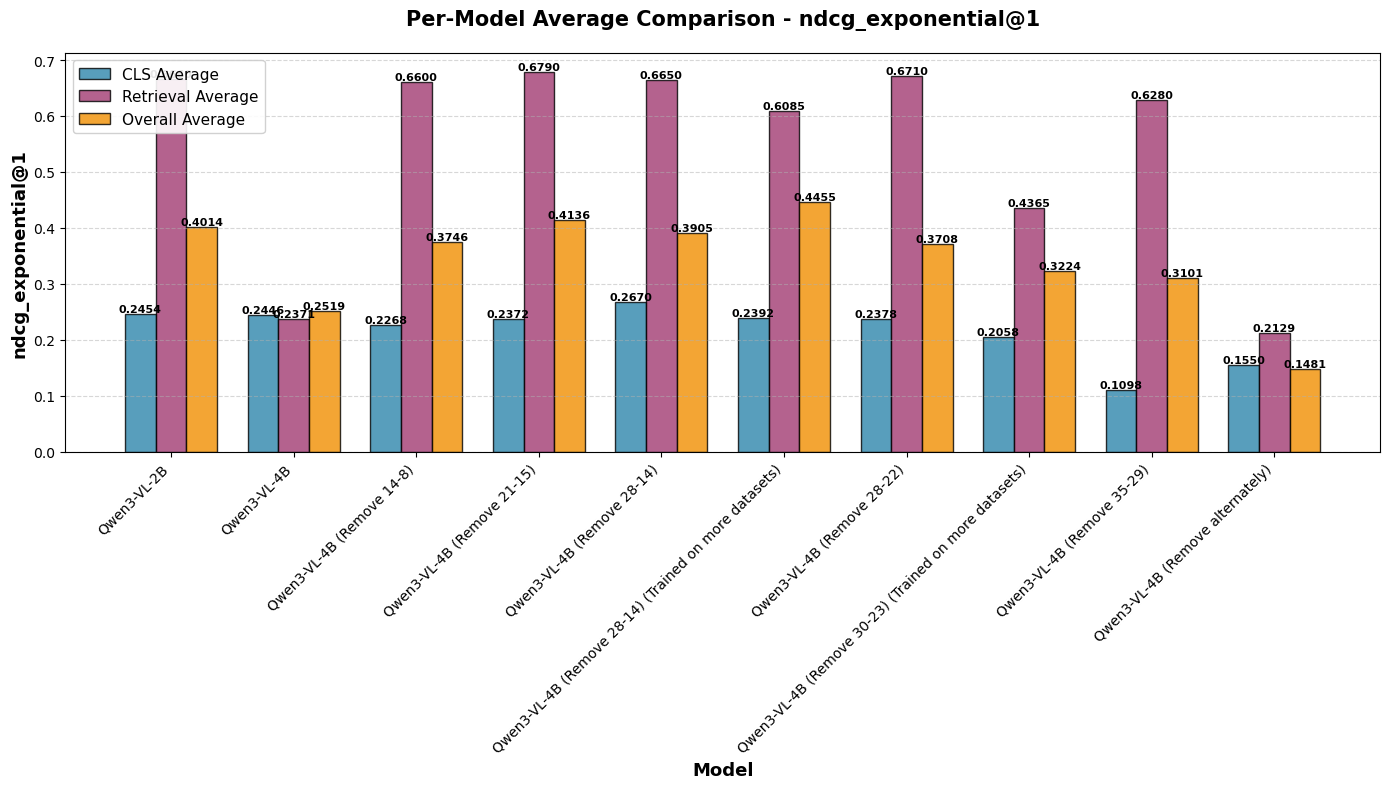


Averages for metric: ndcg_exponential@1
----------------------------------------------------------------------------------------------------
Model                                              CLS Avg         Retrieval Avg        Overall Avg    
----------------------------------------------------------------------------------------------------
Qwen3-VL-2B                                        0.2454          0.6660               0.4014         
Qwen3-VL-4B                                        0.2446          0.2371               0.2519         
Qwen3-VL-4B (Remove 14-8)                          0.2268          0.6600               0.3746         
Qwen3-VL-4B (Remove 21-15)                         0.2372          0.6790               0.4136         
Qwen3-VL-4B (Remove 28-14)                         0.2670          0.6650               0.3905         
Qwen3-VL-4B (Remove 28-14) (Trained on more datasets) 0.2392          0.6085               0.4455         
Qwen3-VL-4B (Remove 28-22)

In [6]:
# =============================================
# Compute and plot per-model averages:
# - CLS task average
# - Retrieval task average
# - Overall average across all tasks
# =============================================

if len(df_results) > 0:
    # Load dataset lists for CLS and Retrieval tasks
    cls_datasets = load_datasets_from_yaml(IMAGE_CLS_YAML)
    retrieval_datasets = load_datasets_from_yaml(RETRIEVAL_YAML)

    print(f"CLS datasets: {cls_datasets}")
    print(f"Retrieval datasets: {retrieval_datasets}")

    # Get all models
    models = sorted(df_results["model_name"].unique())

    # Store averages per model
    model_avg_cls = {}
    model_avg_retrieval = {}
    model_avg_all = {}

    # Compute averages for each metric
    for metric in METRICS:
        if df_results[metric].notna().sum() == 0:
            continue

        print(f"\nComputing averages for metric: {metric} ...")

        # Compute per-model averages
        for model in models:
            model_data = df_results[df_results["model_name"] == model]

            # CLS task average
            cls_data = model_data[model_data["dataset"].isin(cls_datasets)]
            cls_values = cls_data[metric].dropna()
            if len(cls_values) > 0:
                model_avg_cls[model] = model_avg_cls.get(model, {})
                model_avg_cls[model][metric] = cls_values.mean()

            # Retrieval task average
            retrieval_data = model_data[model_data["dataset"].isin(retrieval_datasets)]
            retrieval_values = retrieval_data[metric].dropna()
            if len(retrieval_values) > 0:
                model_avg_retrieval[model] = model_avg_retrieval.get(model, {})
                model_avg_retrieval[model][metric] = retrieval_values.mean()

            # Overall average across all tasks
            all_values = model_data[metric].dropna()
            if len(all_values) > 0:
                model_avg_all[model] = model_avg_all.get(model, {})
                model_avg_all[model][metric] = all_values.mean()

        # Plot
        fig, ax = plt.subplots(figsize=(14, 8))

        x = np.arange(len(models))
        width = 0.25  # bar width

        # Prepare values
        cls_values_list = [model_avg_cls.get(model, {}).get(metric, 0) for model in models]
        retrieval_values_list = [model_avg_retrieval.get(model, {}).get(metric, 0) for model in models]
        all_values_list = [model_avg_all.get(model, {}).get(metric, 0) for model in models]

        # Draw bars (no icons, English labels)
        bars1 = ax.bar(
            x - width,
            cls_values_list,
            width,
            label="CLS Average",
            color="#2E86AB",
            alpha=0.8,
            edgecolor="black",
            linewidth=1,
        )
        bars2 = ax.bar(
            x,
            retrieval_values_list,
            width,
            label="Retrieval Average",
            color="#A23B72",
            alpha=0.8,
            edgecolor="black",
            linewidth=1,
        )
        bars3 = ax.bar(
            x + width,
            all_values_list,
            width,
            label="Overall Average",
            color="#F18F01",
            alpha=0.8,
            edgecolor="black",
            linewidth=1,
        )

        # Annotate values on bars
        def autolabel(bars):
            for bar in bars:
                height = bar.get_height()
                if height > 0:
                    ax.text(
                        bar.get_x() + bar.get_width() / 2.0,
                        height,
                        f"{height:.4f}",
                        ha="center",
                        va="bottom",
                        fontsize=8,
                        fontweight="bold",
                    )

        autolabel(bars1)
        autolabel(bars2)
        autolabel(bars3)

        # Labels and title (English)
        ax.set_xlabel("Model", fontsize=13, fontweight="bold")
        ax.set_ylabel(metric, fontsize=13, fontweight="bold")
        ax.set_title(f"Per-Model Average Comparison - {metric}", fontsize=15, fontweight="bold", pad=20)

        ax.set_xticks(x)
        ax.set_xticklabels(models, rotation=45, ha="right", fontsize=10)

        ax.legend(fontsize=11, framealpha=0.9, loc="upper left")
        ax.grid(True, linestyle="--", alpha=0.5, axis="y")

        plt.tight_layout()
        plt.show()

        # Print table values (English)
        print(f"\nAverages for metric: {metric}")
        print("-" * 100)
        header = f"{'Model':<50} {'CLS Avg':<15} {'Retrieval Avg':<20} {'Overall Avg':<15}"
        print(header)
        print("-" * 100)

        for model in models:
            cls_val = model_avg_cls.get(model, {}).get(metric, 0)
            ret_val = model_avg_retrieval.get(model, {}).get(metric, 0)
            all_val = model_avg_all.get(model, {}).get(metric, 0)
            print(f"{model:<50} {cls_val:<15.4f} {ret_val:<20.4f} {all_val:<15.4f}")

        print(f"\nChart generated for metric: {metric}")
else:
    print("No data available for visualization.")


Data Summary

Summary by dataset and model (hit@1):
model_name      17Dec_Qwen3VL2B_original-Qwen/qwen-Qwen3-VL-2B-Instruct  \
dataset                                                                   
Country211                                                  0.035         
EDIS                                                          NaN         
HatefulMemes                                                0.491         
N24News                                                     0.173         
Place365                                                    0.221         
VOC2007                                                     0.307         
VisualNews_i2t                                                NaN         
VisualNews_t2i                                                NaN         
WebQA                                                         NaN         

model_name      17Dec_Qwen3VL4B_rmv_35_7-Qwen/qwen-Qwen3-VL-4B-Instruct  \
dataset                                        

In [13]:
# #region agent log
# Debug: Check if remove_alternately model MSCOCO data is loaded
import json
import time

debug_log_path = '/home/infres/zzhu-24/PRIM/VLM2Vec/.cursor/debug.log'

# Check df_results for remove_alternately model and MSCOCO datasets
if 'df_results' in globals() and len(df_results) > 0:
    remove_alt_data = df_results[df_results['model_name'] == 'Qwen3-VL-4B (Remove alternately)']
    mscoco_data = df_results[df_results['dataset'].isin(['MSCOCO_i2t', 'MSCOCO_t2i'])]
    remove_alt_mscoco = df_results[
        (df_results['model_name'] == 'Qwen3-VL-4B (Remove alternately)') & 
        (df_results['dataset'].isin(['MSCOCO_i2t', 'MSCOCO_t2i']))
    ]
    
    with open(debug_log_path, 'a') as f:
        f.write(json.dumps({
            "sessionId": "debug-session",
            "runId": "check-data",
            "hypothesisId": "A",
            "location": "analyze2.ipynb:debug",
            "message": "Checking remove_alternately MSCOCO data",
            "data": {
                "total_rows": len(df_results),
                "remove_alt_total": len(remove_alt_data),
                "mscoco_total": len(mscoco_data),
                "remove_alt_mscoco": len(remove_alt_mscoco),
                "remove_alt_datasets": remove_alt_data['dataset'].unique().tolist() if len(remove_alt_data) > 0 else [],
                "remove_alt_mscoco_rows": remove_alt_mscoco.to_dict('records') if len(remove_alt_mscoco) > 0 else []
            },
            "timestamp": int(time.time() * 1000)
        }) + '\n')
    
    print(f"🔍 Debug: remove_alternately model total rows: {len(remove_alt_data)}")
    print(f"🔍 Debug: MSCOCO datasets total rows: {len(mscoco_data)}")
    print(f"🔍 Debug: remove_alternately + MSCOCO rows: {len(remove_alt_mscoco)}")
    if len(remove_alt_mscoco) > 0:
        print(f"🔍 Debug: Found data! {remove_alt_mscoco[['model_name', 'dataset', 'layer', 'hit@1']].to_string()}")
    else:
        print("⚠️  No remove_alternately + MSCOCO data found in df_results")
# #endregion

🔍 Debug: remove_alternately model total rows: 330
🔍 Debug: MSCOCO datasets total rows: 144
🔍 Debug: remove_alternately + MSCOCO rows: 60
🔍 Debug: Found data!                            model_name     dataset     layer  hit@1
55   Qwen3-VL-4B (Remove alternately)  MSCOCO_i2t  layer_10  0.001
56   Qwen3-VL-4B (Remove alternately)  MSCOCO_t2i  layer_10  0.000
66   Qwen3-VL-4B (Remove alternately)  MSCOCO_i2t  layer_31  0.576
67   Qwen3-VL-4B (Remove alternately)  MSCOCO_t2i  layer_31  0.615
77   Qwen3-VL-4B (Remove alternately)  MSCOCO_i2t   layer_5  0.002
78   Qwen3-VL-4B (Remove alternately)  MSCOCO_t2i   layer_5  0.006
88   Qwen3-VL-4B (Remove alternately)  MSCOCO_i2t   layer_8  0.001
89   Qwen3-VL-4B (Remove alternately)  MSCOCO_t2i   layer_8  0.000
99   Qwen3-VL-4B (Remove alternately)  MSCOCO_i2t   layer_2  0.002
100  Qwen3-VL-4B (Remove alternately)  MSCOCO_t2i   layer_2  0.003
110  Qwen3-VL-4B (Remove alternately)  MSCOCO_i2t  layer_36  0.648
111  Qwen3-VL-4B (Remove alternately) 